<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_plus_Incl_Angle_0.9_Acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
np.random.seed(666)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from subprocess import check_output
from matplotlib import pyplot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

In [2]:
from google.colab import drive

drive.mount('/content/drive')
data = pd.read_json('/content/drive/MyDrive/Iceberg_Ship_Classification/train.json')

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


Delete all observations without an inclination angle (133 in total) instead of replacing it with some random values... Then rescale the inclination angle between -1 and 1

In [3]:
print(len(data))
data.inc_angle = data.inc_angle.replace('na', np.nan)

#data.inc_angle = data.inc_angle.astype(float).fillna(0.0)
data = data.dropna(axis=0, how='any')
print(len(data))
print(data.inc_angle.min())
print(data.inc_angle.max())
data.inc_angle = 2*(data.inc_angle - 20)/(50-20)-1
print(data.inc_angle.min())
print(data.inc_angle.max())

1604
1471
24.7546
45.9375
-0.6830266666666667
0.7291666666666667


In [4]:
def lee_filter(img, size):
    # From here: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [5]:
def prepare_data(data):
  x_angle = np.array(data["inc_angle"])

  # Get the labels (y-values)
  labels = np.array(data["is_iceberg"])

  # Create empty list for the images
  imgs = []
  for i, row in data.iterrows():
      # Reshape list to image
      hh  = np.reshape(row["band_1"], (75, 75))
      hv  = np.reshape(row["band_2"], (75, 75))
      b3  = hh + hv

      hh = lee_filter(hh, 20)
      hv = lee_filter(hv, 20)
      b3 = lee_filter(b3, 20)      
        
      # Rescale images between 0 and 1 for faster convergence rate
      hh = (hh - hh.min())/(hh.max()-hh.min())
      hv = (hv - hv.min())/(hv.max()-hv.min())
      b3 = (b3 - b3.min())/(b3.max()-b3.min())      

      # Stack the bands and append them to imgs
      imgs.append(np.dstack((hh, hv, b3)))
      
  # Split dataset into training (70%)  and validation (30 %)
  x_train, x_val, x_angle_train, x_angle_val, y_train, y_val = train_test_split(imgs, 
                                                    x_angle,
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state=0)
  # Then split validation dataset into validation (20 %) and testing (10 %)
  x_val, x_test, x_angle_val, x_angle_test, y_val, y_test = train_test_split(x_val,
                                                  x_angle_val,
                                                  y_val,
                                                  test_size=(1/3),
                                                  random_state=0)

  x_train = np.array(x_train)
  x_test = np.array(x_test)
  x_val = np.array(x_val)
  x_angle_test = np.array(x_angle_test)
  x_angle_train = np.array(x_angle_train)
  x_angle_val = np.array(x_angle_val)
  return x_train, x_val, x_test, x_angle_train, x_angle_val, x_angle_test, y_train, y_val, y_test

In [6]:
x_train, x_val, x_test, x_angle_train, x_angle_val, x_angle_test, y_train, y_val, y_test = prepare_data(data)
print("Number of samples for training: " + str(len(x_train)) + " (" + str(round(len(x_train)/len(data), 4)*100) + " %)")
print("Number of samples for validation: " + str(len(x_val)) + " (" + str(round(len(x_val)/len(data), 4)*100) + " %)")
print("Number of samples for testing: " + str(len(x_test)) + " (" + str(round(len(x_test)/len(data), 4)*100) + " %)")

Number of samples for training: 1029 (69.95 %)
Number of samples for validation: 294 (19.99 %)
Number of samples for testing: 148 (10.059999999999999 %)


Create two data generators for both images and the inclination angle and combine them. I have the code from https://www.kaggle.com/sinkie/keras-data-augmentation-with-multiple-inputs, but still don't understand what this is doing exactly...

In [8]:
# From here: https://www.kaggle.com/sinkie/keras-data-augmentation-with-multiple-inputs
batch_size = 32

gen = ImageDataGenerator(
      rotation_range = 45,
      width_shift_range = 0.15,
      height_shift_range = 0.15,
      shear_range = 0.15,
      zoom_range = 0.15,
      horizontal_flip = True,
      vertical_flip = True,
      fill_mode = 'nearest')

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=666)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(x_train, x_angle_train, y_train)


In [9]:
# train_generator, val_generator = DataGenerators(x_train, x_val, y_train, y_val)

In [10]:
def create_model(optimizer):
  ac_fct      = "relu"
  #momentum    = 0

  input_img   = Input(shape=(75, 75 ,3), name="X_img")
  input_angle = Input(shape=[1], name="angle")

  #cnn = BatchNormalization()(input_img)
  cnn = Conv2D(16, kernel_size=(3,3), activation = "relu")(input_img)
  cnn = Conv2D(16, kernel_size=(3,3), activation = "relu")(cnn)
  cnn = MaxPooling2D((2,2))(cnn)
  cnn = Dropout(0.1) (cnn)

  cnn = Conv2D(32, kernel_size=(3,3), activation = "relu")(cnn)
  #cnn = Conv2D(32, kernel_size=(3,3), activation = "relu")(cnn)
  cnn = MaxPooling2D((2,2)) (cnn)
  cnn = Dropout(0.1) (cnn)

  cnn = Conv2D(64, kernel_size=(3,3), activation = "relu")(cnn)
  #cnn = Conv2D(64, kernel_size=(3,3), activation = "relu") (cnn)
  cnn = MaxPooling2D((2,2)) (cnn)
  cnn = Dropout(0.1) (cnn)  

  cnn = Conv2D(128, kernel_size=(3,3), activation = "relu")(cnn)
  cnn = Conv2D(128, kernel_size=(3,3), activation = "relu") (cnn)
  cnn = MaxPooling2D((2,2)) (cnn)
  cnn = Dropout(0.1) (cnn)  
  

  cnn = GlobalMaxPooling2D() (cnn)

  #angle = BatchNormalization(momentum=0)(input_angle)

  concat = (Concatenate()([cnn, input_angle]))

  dense = Dense(32, activation="relu") (concat)
  # dense = BatchNormalization() (dense)
  # dense = Dropout(0.2)(dense)
  
  #dense = Dense(128, activation="relu") (dense)
  #dense = BatchNormalization() (dense)
  #dense = Dropout(0.2)(dense)

  #dense = Dense(128, activation="relu") (dense)
  #dense = BatchNormalization() (dense)
  #dense = Dropout(0.2)(dense)

  output = Dense(1, activation="sigmoid")(dense)

  model = Model([input_img, input_angle], output)
  #optimizer = Adam(lr=0.1, epsilon=1e-08, decay=0.0)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

epochs = 250
# learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# from keras.optimizers import Adadelta
model = create_model(optimizer = Adam())
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_img (InputLayer)              [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 73, 73, 16)   448         X_img[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 71, 71, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 35, 35, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Train the Model

In [11]:
history = model.fit(gen_flow, validation_data=([x_val, x_angle_val], y_val),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs)


Epoch 1/250
32/32 [==============================] - 7s 119ms/step - loss: 0.6944 - accuracy: 0.4990 - val_loss: 0.6855 - val_accuracy: 0.5306
Epoch 2/250
32/32 [==============================] - 3s 95ms/step - loss: 0.6804 - accuracy: 0.6111 - val_loss: 0.7265 - val_accuracy: 0.5680
Epoch 3/250
32/32 [==============================] - 3s 96ms/step - loss: 0.6710 - accuracy: 0.6360 - val_loss: 0.6458 - val_accuracy: 0.6122
Epoch 4/250
32/32 [==============================] - 3s 96ms/step - loss: 0.6136 - accuracy: 0.6707 - val_loss: 0.5886 - val_accuracy: 0.6599
Epoch 5/250
32/32 [==============================] - 3s 96ms/step - loss: 0.5909 - accuracy: 0.6953 - val_loss: 0.5543 - val_accuracy: 0.7109
Epoch 6/250
32/32 [==============================] - 3s 94ms/step - loss: 0.5771 - accuracy: 0.6919 - val_loss: 0.5306 - val_accuracy: 0.7177
Epoch 7/250
32/32 [==============================] - 3s 94ms/step - loss: 0.5596 - accuracy: 0.7024 - val_loss: 0.5329 - val_accuracy: 0.7245
Epoch

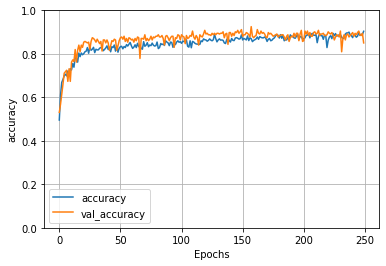

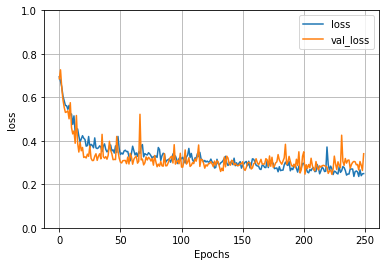

In [12]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.ylim([0,1])
  plt.grid()
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
results = model.evaluate([x_test, x_angle_test], y_test)

5/5 [==============================] - 0s 23ms/step - loss: 0.3084 - accuracy: 0.8851
